In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from einops import rearrange

In [2]:
def rearrange_sample(house):
    # this rearranges the training sample into an x y z m shape
    world = rearrange(house, 'z y x m -> x y z m')
    return world

In [3]:
def trim_world_empty(world):
    # this removes empty voxels sorrounding a world
    arr_slices = tuple(np.s_[curr_arr.min():curr_arr.max() + 1] for curr_arr in world[:,:,:,0].nonzero())
    return world[arr_slices]

In [4]:
def pad_world(world):
    # this pads a world to the smallest cubic volume that it can fit in
    (x, y, z, m) = world.shape
    min_dim = max(world.shape[0:3])
    world = np.pad(world, ((0, min_dim - x),(0, min_dim - y),(0, min_dim - z), (0, 0)), 'constant')
    return world

In [5]:
# an array for some sample examples
sample_houses_dirs = ["house_data/houses/workdir.2018-06-22-16:39:03.ip-172-31-9-250/schematic.npy", # match box
    "house_data/houses/workdir.2018-06-23-07:16:40.ip-172-31-5-36/schematic.npy", # a house with deck
    "house_data/houses/workdir.2018-06-22-20:45:54.ip-172-31-2-250/schematic.npy", # quartz house
    "house_data/houses/workdir.2018-06-23-08:09:44.ip-172-31-10-251/schematic.npy", # tree house
    "house_data/houses/workdir.2018-06-22-19:13:10.ip-172-31-13-79/schematic.npy", # normal hut
    "house_data/houses/workdir.2018-06-23-18:11:04.ip-172-31-0-19/schematic.npy", # normal hut
]

sample_houses = [pad_world(trim_world_empty(rearrange_sample(np.load(dir)))) 
    for dir in sample_houses_dirs] # a list of houses

print(len(sample_houses)) # the number of houses loaded

print(sample_houses[1].shape) # comes in (y, z, x, id/meta) order (y is the height in minecraft)
print(sample_houses[1][4, 3 ,3]) # this contains id/meta

6
(21, 21, 21, 2)
[0 0]


In [6]:
def visualise_world(world):

    (x, y, z, m) = world.shape
    
    voxelarray = world[:,:,:,0]

    colors = np.full(voxelarray.shape, '#FFF', dtype=object)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d', adjustable='box')
    ax.voxels(voxelarray, facecolors=colors, edgecolor="k")

    plt.show()

In [7]:
visualise_world(sample_houses[1])

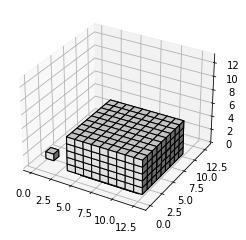

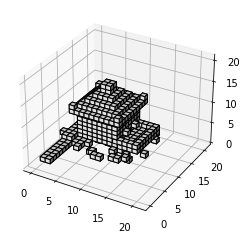

In [ ]:
[visualise_world(world) for world in sample_houses]